# CMPUT 655 - Assignment 4
## Lucas Cruz

Kept it simple this time, hope it helps to mark it.

The plots and discussions were included in the PDF submitted.

## Part I and II

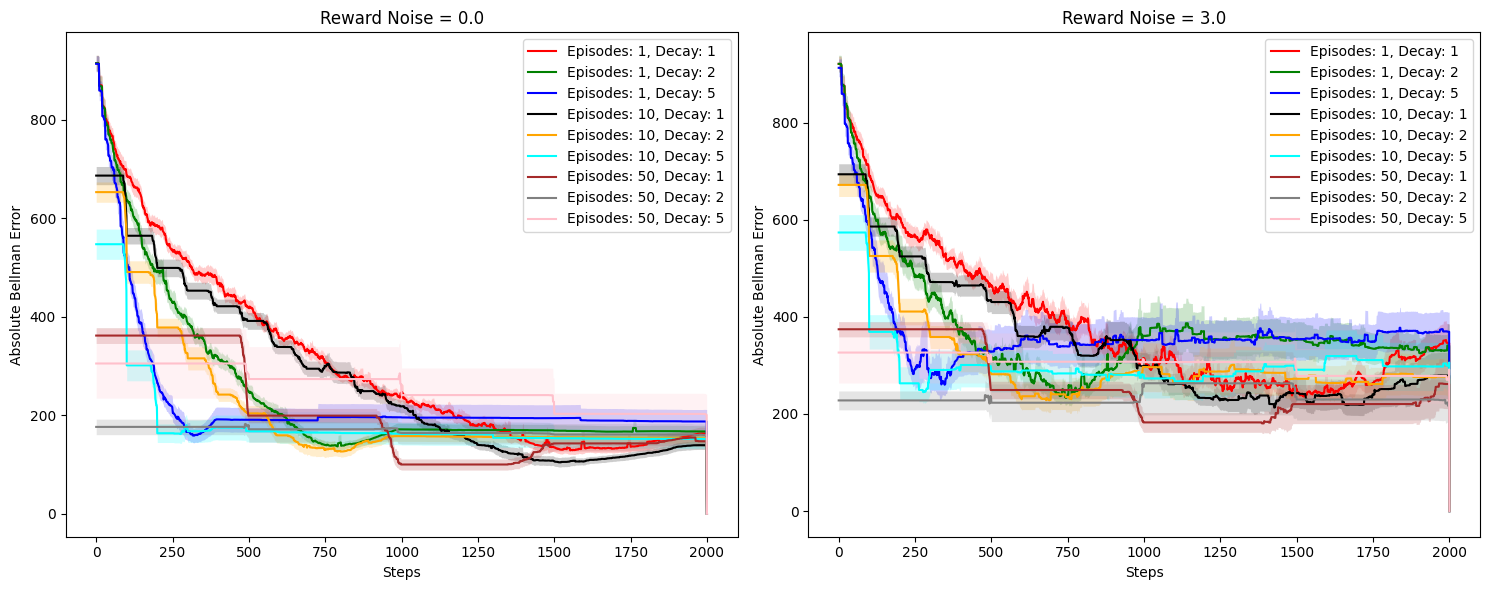

In [38]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

env = gym.make("Gym-Gridworlds/Penalty-3x3-v0")
n_states = env.observation_space.n
n_actions = env.action_space.n

R = np.zeros((n_states, n_actions))
P = np.zeros((n_states, n_actions, n_states))

env.reset()
for s in range(n_states):
    for a in range(n_actions):
        env.unwrapped.set_state(s)
        s_next, r, terminated, _, _ = env.step(a)
        R[s, a] = r
        P[s, a, s_next] = 1.0

# The terminal state has no outgoing transitions
# For non-terminal states, ensure the probabilities sum to 1
for s in range(n_states):
    for a in range(n_actions):
        if P[s, a].sum() == 0:
            P[s, a, s] = 1.0  # Stay in the same state if no transition

def epsilon_greedy_probs(Q_s, epsilon):
    """Compute action probabilities using epsilon-greedy policy."""
    n_actions = len(Q_s)
    probs = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q_s)
    probs[best_action] += 1.0 - epsilon
    return probs

def bellman_q(pi, gamma):
    """Compute the true Q-function under policy pi."""
    # Reshape R and P for vectorized computation
    R_flat = R.reshape(-1)  # Shape: (n_states * n_actions,)
    P_pi = np.zeros((n_states * n_actions, n_states * n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            idx_sa = s * n_actions + a
            for s_prime in range(n_states):
                for a_prime in range(n_actions):
                    idx_sprime_aprime = s_prime * n_actions + a_prime
                    P_pi[idx_sa, idx_sprime_aprime] += P[s, a, s_prime] * pi[s_prime, a_prime]
    
    # Solve (I - gamma * P_pi) * Q = R
    I = np.eye(n_states * n_actions)
    Q_flat = np.linalg.solve(I - gamma * P_pi, R_flat)
    Q = Q_flat.reshape(n_states, n_actions)
    return Q

def eps_greedy_action(Q, s, eps):
    """Select an action using epsilon-greedy policy."""
    probs = epsilon_greedy_probs(Q[s], eps)
    return np.random.choice(n_actions, p=probs)

def episode(env, Q, eps, seed):
    """Generate an episode following the epsilon-greedy policy."""
    data = {"s": [], "a": [], "r": []}
    s, _ = env.reset(seed=seed)
    done = False
    while not done:
        a = eps_greedy_action(Q, s, eps)
        s_next, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        data["s"].append(s)
        data["a"].append(a)
        data["r"].append(r)
        s = s_next
    return data

def monte_carlo(env, Q, gamma, eps_decay, max_steps, episodes_per_iteration, use_is):    
    total_interactions = 0
    last_update = 0
    bellman_errors = np.empty(max_steps+1) # to account for the first error
    eps = 1.0

    # Compute initial policy pi for Bellman error
    pi = np.array([epsilon_greedy_probs(Q[s], eps) for s in range(n_states)])
    bellman_error = np.abs(Q - bellman_q(pi, gamma)).mean()
    bellman_errors[0] = bellman_error

    while total_interactions < max_steps:
        returns_sum = np.zeros((n_states, n_actions))
        returns_count = np.zeros((n_states, n_actions))
        C = np.zeros((n_states, n_actions))  # For IS

        for _ in range(episodes_per_iteration):
            episode_data = episode(env, Q, eps, seed=None)
            episode_steps = len(episode_data["s"])
            total_interactions += episode_steps
            G = 0.0
            W = 1.0

            for t in reversed(range(len(episode_data["s"]))):
                s_t = episode_data["s"][t]
                a_t = episode_data["a"][t]
                r_t = episode_data["r"][t]
                G = gamma * G + r_t

                if use_is:
                    # Target policy: epsilon=0.01
                    epsilon_target = 0.01
                    target_probs = epsilon_greedy_probs(Q[s_t], epsilon_target)
                    target_pi = target_probs[a_t]

                    # Behavior policy: current epsilon
                    behavior_probs = epsilon_greedy_probs(Q[s_t], eps)
                    behavior_pi = behavior_probs[a_t]

                    rho = target_pi / behavior_pi
                    W *= rho

                    C[s_t, a_t] += W
                    Q[s_t, a_t] += (W / C[s_t, a_t]) * (G - Q[s_t, a_t])
                else:
                    # MC
                    returns_sum[s_t, a_t] += G
                    returns_count[s_t, a_t] += 1

            eps = max(eps - eps_decay * episode_steps, 0.01)

        if not use_is:
            # Update Q with the average returns
            Q_update = np.divide(
                returns_sum,
                returns_count,
                out=np.zeros_like(Q),
                where=returns_count != 0,
            )
            Q = np.where(returns_count != 0, Q_update, Q)

        # Compute policy pi for Bellman error
        pi = np.array([epsilon_greedy_probs(Q[s], eps) for s in range(n_states)])

        # Compute Bellman error
        bellman_error = np.abs(bellman_q(pi, gamma) - Q).sum()
        total_interactions = min(total_interactions, max_steps) # to avoid out-of-index
        bellman_errors[last_update:total_interactions] = bellman_error
        last_update = total_interactions

    return Q, bellman_errors

def error_shade_plot(ax, data, stepsize, **kwargs):
    y = np.nanmean(data, 0)
    x = np.arange(len(y))
    x = [stepsize * step for step in range(len(y))]
    (line,) = ax.plot(x, y, **kwargs)
    error = np.nanstd(data, axis=0)
    error = 1.96 * error / np.sqrt(data.shape[0])  # 95% confidence interval
    ax.fill_between(x, y - error, y + error, alpha=0.2, linewidth=0.0, color=line.get_color())

# Hyperparameters
init_value = 0.0
gamma = 0.9
max_steps = 2000
horizon = 10

episodes_per_iteration = [1, 10, 50]
decays = [1, 2, 5]
seeds = np.arange(50)

results = np.zeros((
    len(episodes_per_iteration),
    len(decays),
    len(seeds),
    max_steps+1,  # Account for the initial error
))

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 

use_is = False  # Set to True for importance sampling
for ax, reward_noise_std in zip(axs, [0.0, 3.0]):
    ax.set_title(f"Reward Noise = {reward_noise_std}")
    ax.set_prop_cycle(
        color=["red", "green", "blue", "black", "orange", "cyan", "brown", "gray", "pink"]
    )
    ax.set_xlabel("Steps")
    ax.set_ylabel("Absolute Bellman Error")
    env = gym.make(
        "Gym-Gridworlds/Penalty-3x3-v0",
        max_episode_steps=horizon,
        reward_noise_std=reward_noise_std,
    )
    for j, episodes in enumerate(episodes_per_iteration):
        for k, decay in enumerate(decays):
            for i, seed in enumerate(seeds):
                np.random.seed(seed)
                Q = np.zeros((n_states, n_actions)) + init_value
                eps_decay = decay / max_steps
                Q, be = monte_carlo(env, Q, gamma, eps_decay, max_steps, episodes, use_is)
                results[j, k, i] = be[:max_steps+1]
            error_shade_plot(
                ax,
                results[j, k],
                stepsize=1,
                label=f"Episodes: {episodes}, Decay: {decay}",
            )
    ax.legend()

plt.tight_layout()
plt.show()


## Part III

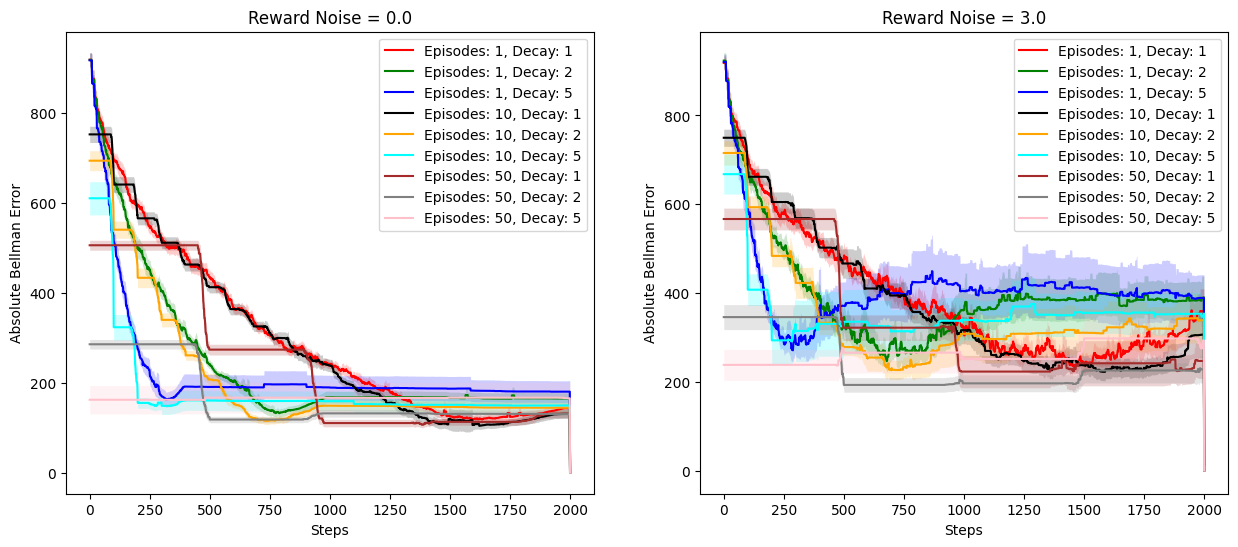

In [41]:
# Hyperparameters
init_value = 0.0
gamma = 0.9
max_steps = 2000
horizon = 10

episodes_per_iteration = [1, 10, 50]
# episodes_per_iteration = [1]
decays = [1, 2, 5]
# decays = [1]
seeds = np.arange(50)
# seeds = np.arange(10)

results = np.zeros((
    len(episodes_per_iteration),
    len(decays),
    len(seeds),
    max_steps+1, # account for the initial error
))

fig, axs = plt.subplots(1, 2, figsize=(15, 6)) 
# plt.ion()
# plt.show()

use_is = True  # repeat with True
for ax, reward_noise_std in zip(axs, [0.0, 3.0]):
    ax.set_title(f"Reward Noise = {reward_noise_std}")
    ax.set_prop_cycle(
        color=["red", "green", "blue", "black", "orange", "cyan", "brown", "gray", "pink"]
    )
    ax.set_xlabel("Steps")
    ax.set_ylabel("Absolute Bellman Error")
    env = gym.make(
        "Gym-Gridworlds/Penalty-3x3-v0",
        max_episode_steps=horizon,
        reward_noise_std=reward_noise_std,
    )
    for j, episodes in enumerate(episodes_per_iteration):
        for k, decay in enumerate(decays):
            for seed in seeds:
                np.random.seed(seed)
                Q = np.zeros((n_states, n_actions)) + init_value
                Q, be = monte_carlo(env, Q, gamma, decay / max_steps, max_steps, episodes, use_is)
                results[j, k, seed] = be
            error_shade_plot(
                ax,
                results[j, k],
                stepsize=1,
                label=f"Episodes: {episodes}, Decay: {decay}",
            )
            ax.legend()
            # plt.draw()
            # plt.pause(0.001)

# plt.ioff()
plt.show()